Using 41 total features: ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'WindGustDir_W', 'WindGustDir_SE', 'WindGustDir_E', 'WindGustDir_N', 'WindGustDir_SSE', 'WindGustDir_S', 'WindGustDir_WSW', 'WindGustDir_SW', 'WindDir9am_N', 'WindDir9am_SE', 'WindDir9am_E', 'WindDir9am_SSE', 'WindDir9am_NW', 'WindDir9am_S', 'WindDir9am_W', 'WindDir9am_SW', 'WindDir3pm_SE', 'WindDir3pm_W', 'WindDir3pm_S', 'WindDir3pm_WSW', 'WindDir3pm_SW', 'WindDir3pm_SSE', 'WindDir3pm_N', 'WindDir3pm_WNW']
Final feature matrix shape: (142193, 41)
Dataset shape: (142193, 41), Labels: (array([0, 1]), array([110316,  31877]))
Plotting initial feature weights


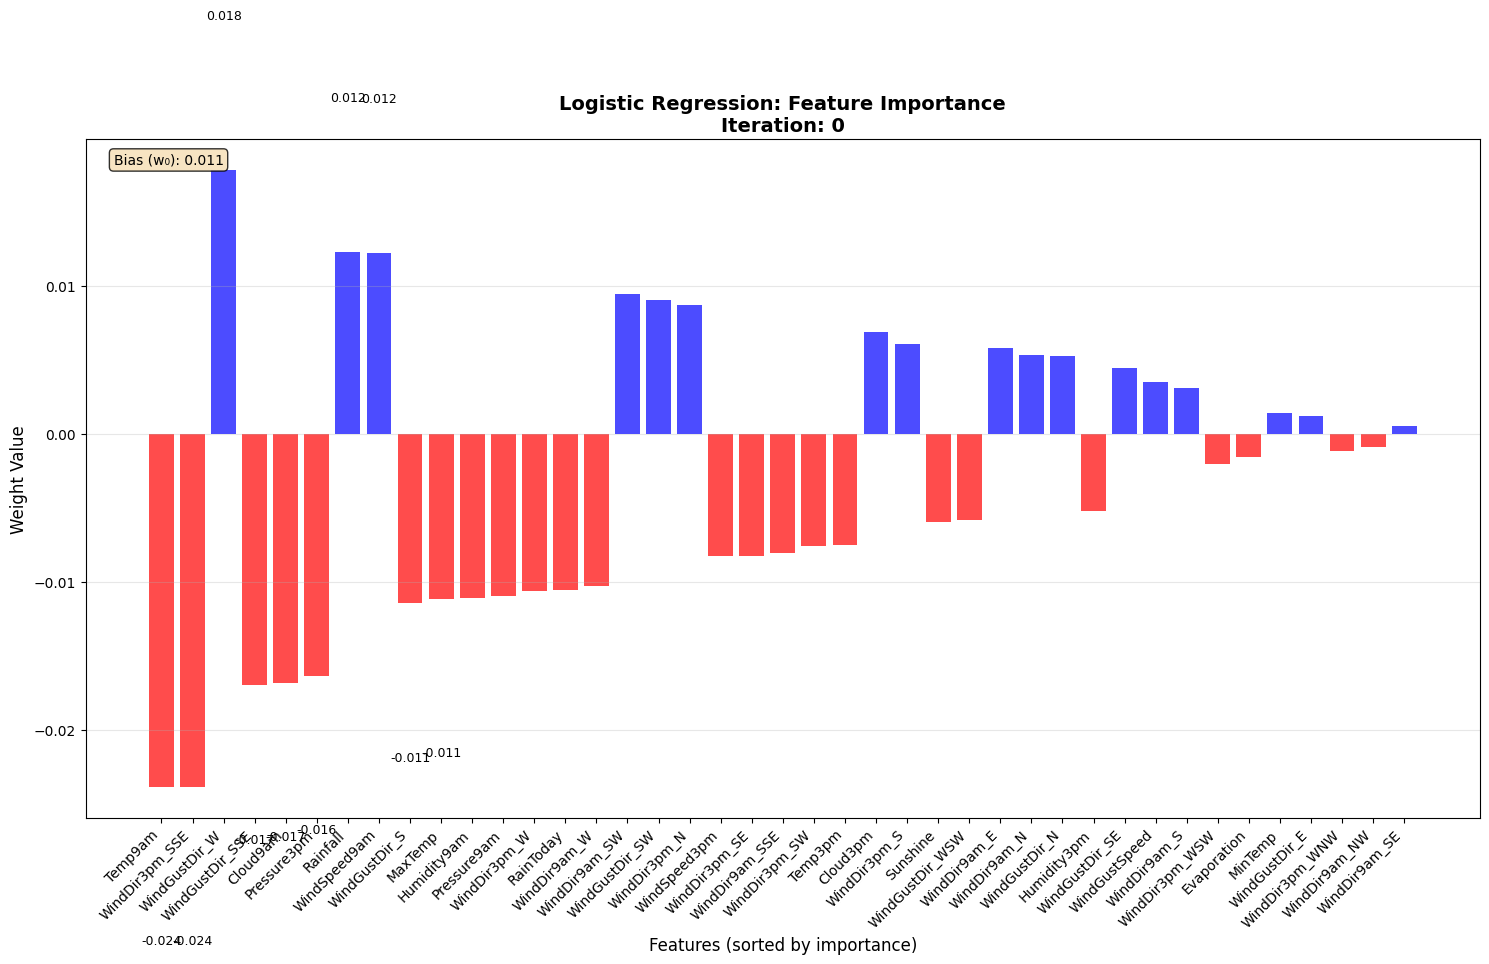


Starting training
Iteration 0, Cost: 0.6939
Iteration 10, Cost: 0.6060
Iteration 50, Cost: 0.4768
Iteration 1000, Cost: 0.3641

Final iteration 1999, Cost: 0.3627


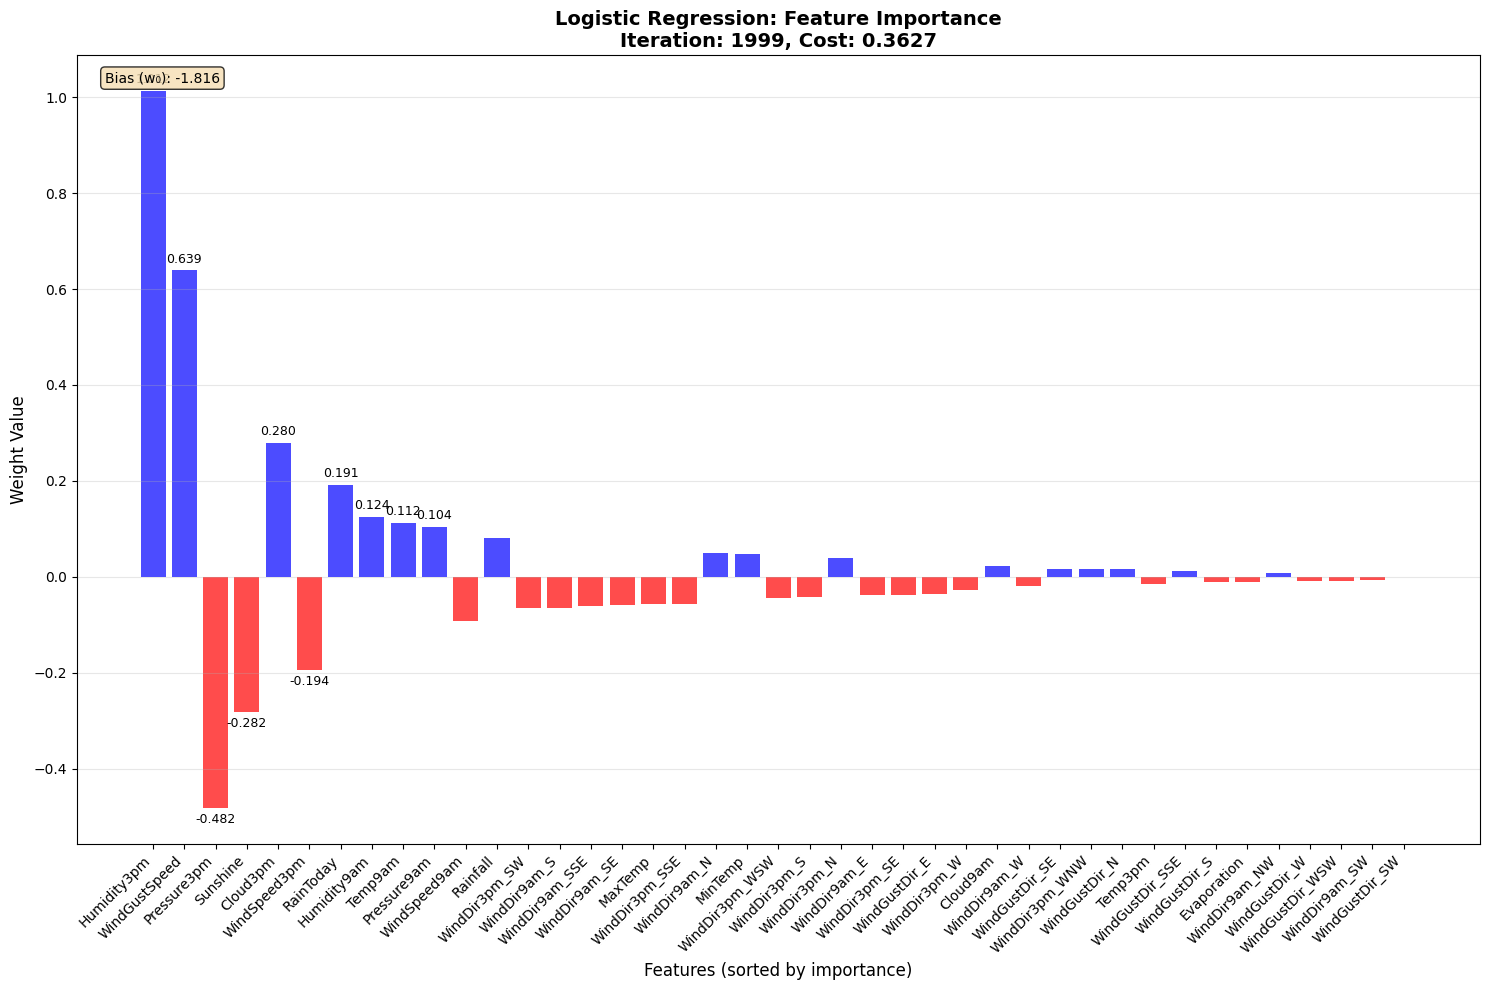

Final parameters (w):
[-1.81614267e+00  4.84484006e-02 -5.59990516e-02  8.12680500e-02
 -1.09392063e-02 -2.82208750e-01  6.38813533e-01 -9.15809917e-02
 -1.94122829e-01  1.24213139e-01  1.01235454e+00  1.03628432e-01
 -4.81753454e-01  2.20782982e-02  2.79673842e-01  1.11892648e-01
 -1.47328590e-02  1.91027345e-01 -8.27166345e-03  1.68510980e-02
 -3.61188416e-02  1.56647633e-02  1.22836825e-02 -1.16515841e-02
 -7.61169571e-03  5.63431020e-04  5.06937073e-02 -5.77439804e-02
 -3.73620122e-02 -6.11382098e-02  8.65667287e-03 -6.57211935e-02
 -1.99371509e-02 -6.74140879e-03 -3.73475048e-02 -2.80260898e-02
 -4.19534122e-02 -4.45428583e-02 -6.57905971e-02 -5.58794740e-02
  4.01918190e-02  1.65818761e-02]


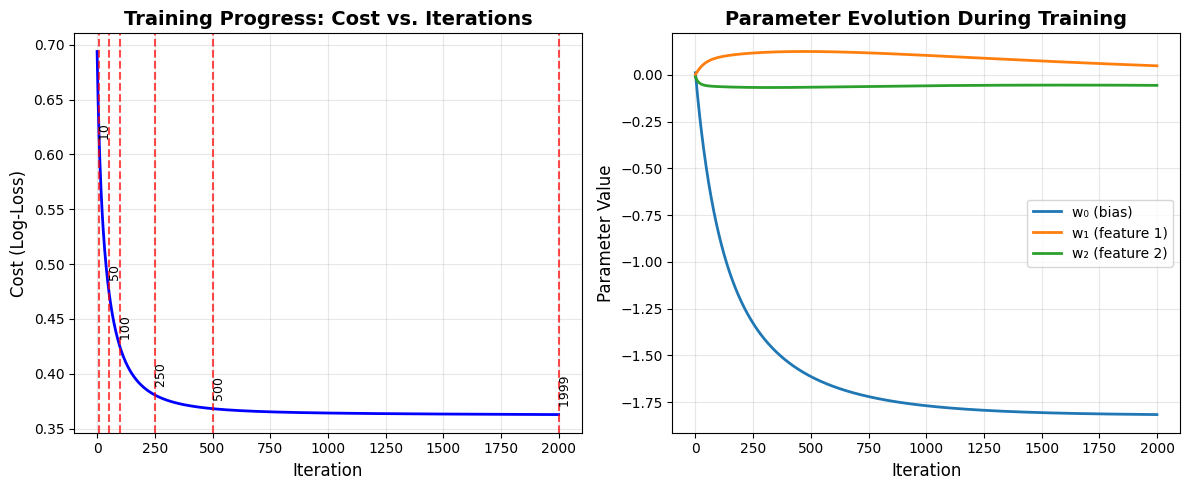

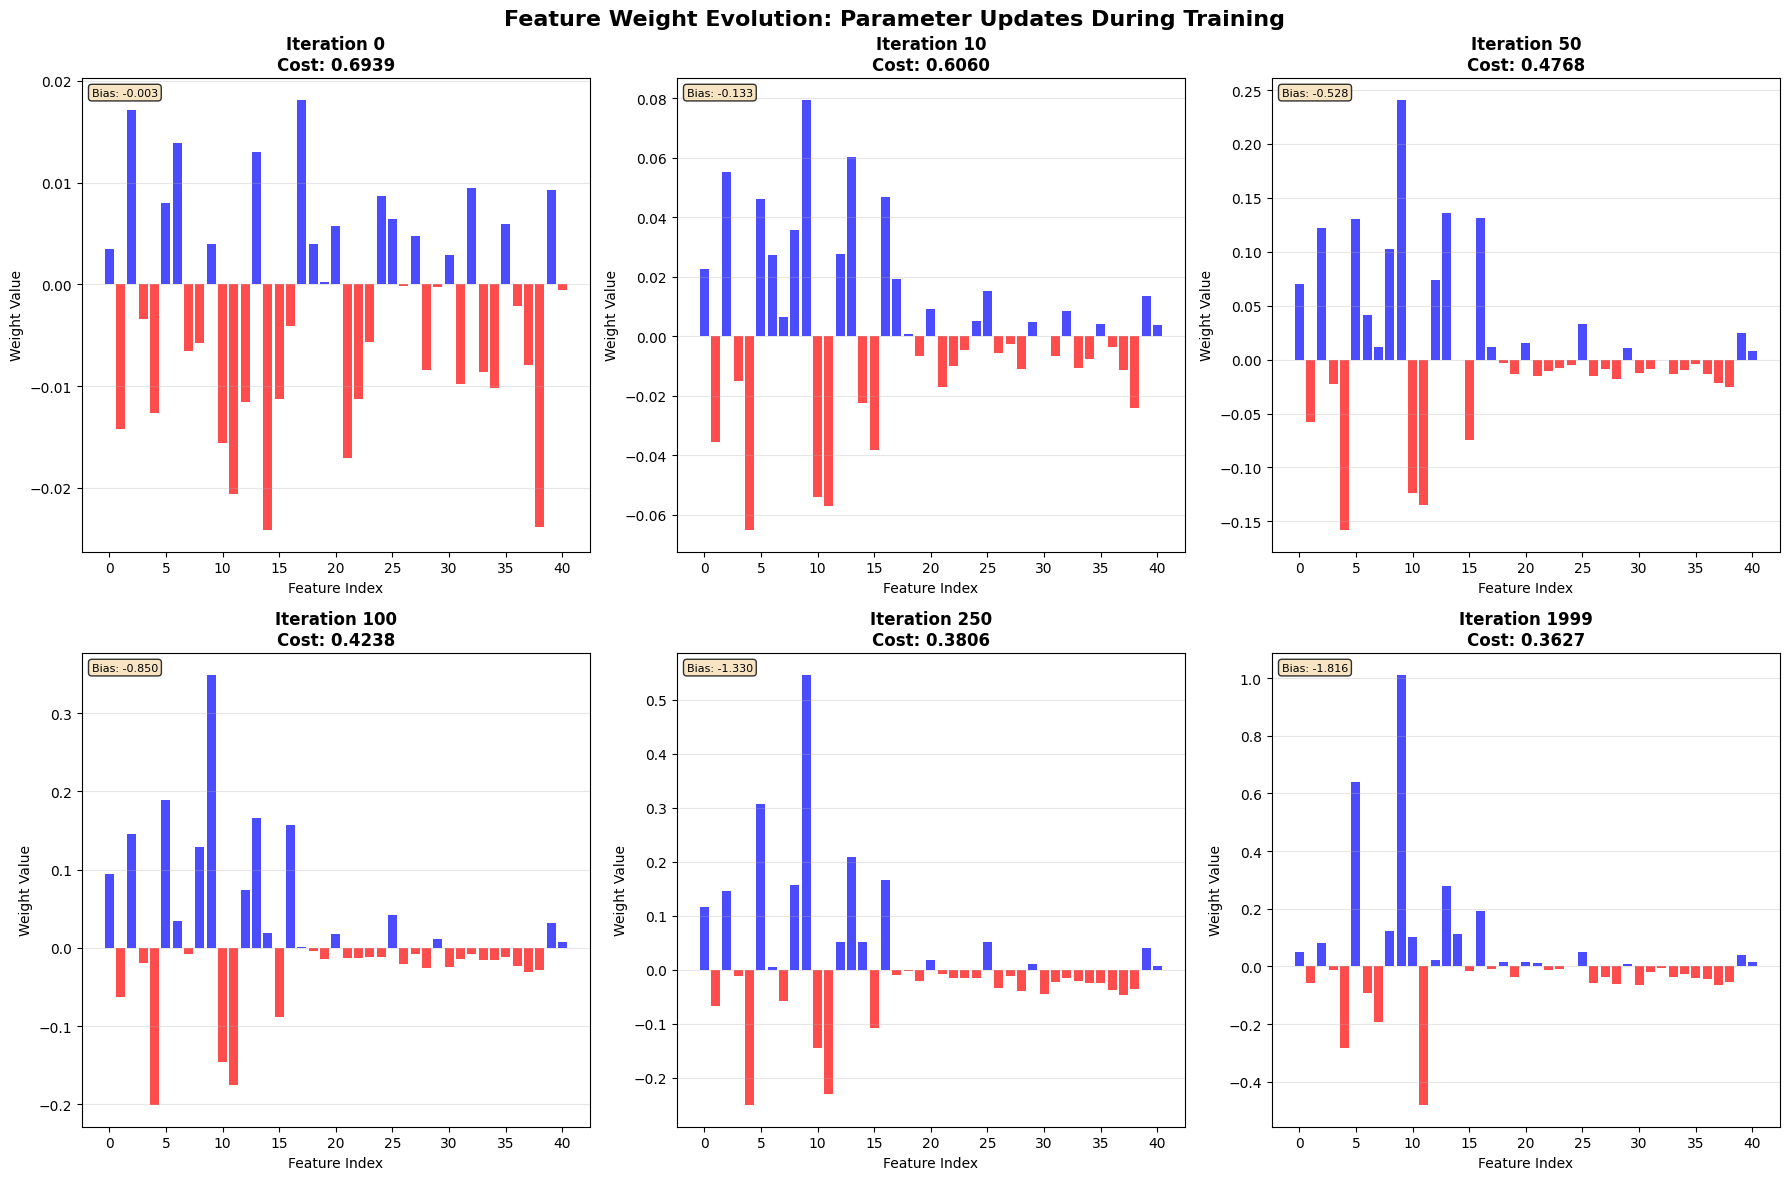

Plotting cost sensitivity for parameter indices: [10  6 12]


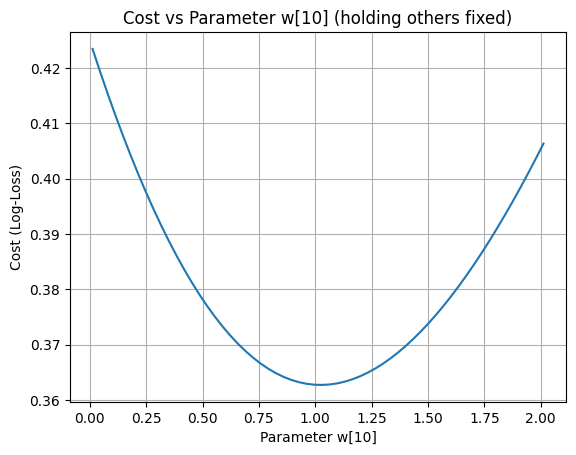

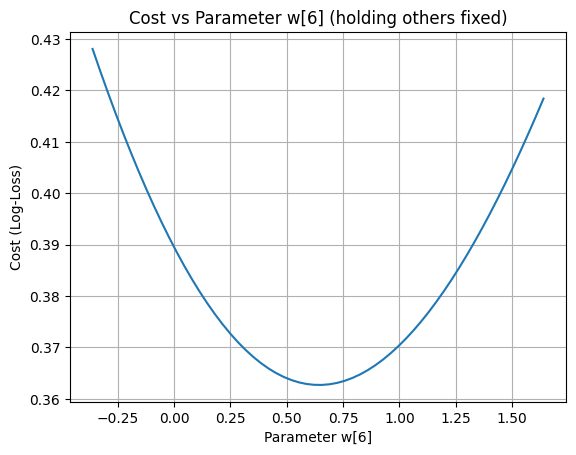

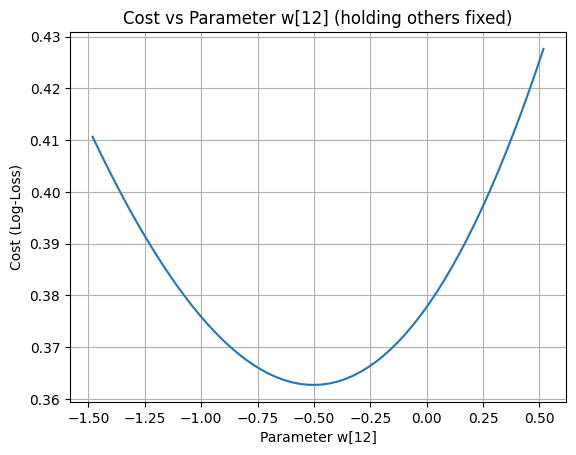

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jsphyg/weather-dataset-rattle-package")

print("Path to dataset files:", path)

def load_data_2d():
    np.random.seed(67)
    
    n_samples = 300    
    
    X0 = np.random.multivariate_normal([-1, -1], [[0.8, 0.2], [0.2, 0.8]], n_samples//2)
    y0 = np.zeros(n_samples//2)

    X1 = np.random.multivariate_normal([1, 1], [[0.8, -0.2], [-0.2, 0.8]], n_samples//2)
    y1 = np.ones(n_samples//2)
    
    X = np.vstack([X0, X1])
    y = np.hstack([y0, y1])
    
    indices = np.random.permutation(len(X))
    X, y = X[indices], y[indices]
    
    return X, y, ['Feature_1', 'Feature_2']

def load_data():
    df = pd.read_csv(path+'/weatherAUS.csv')
    
    df = df.dropna(subset=['RainTomorrow'])
    
    numerical_features = [
        'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
        'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 
        'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
        'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'
    ]
    
    df_features = df[numerical_features].fillna(df[numerical_features].median())

    if 'RainToday' in df.columns:
        df['RainToday_encoded'] = df['RainToday'].map({'No': 0, 'Yes': 1}) #change raintoday to be 0/1 to be fit
        df_features['RainToday'] = df['RainToday_encoded'].fillna(0)
    
    categorical_features = ['WindGustDir', 'WindDir9am', 'WindDir3pm']
    for cat_feature in categorical_features:
        if cat_feature in df.columns:
            top_directions = df[cat_feature].value_counts().head(8).index
            for direction in top_directions:
                df_features[f'{cat_feature}_{direction}'] = (df[cat_feature] == direction).astype(int)
    
    print(f"Using {len(df_features.columns)} total features: {list(df_features.columns)}")

    le_target = LabelEncoder()
    y = le_target.fit_transform(df['RainTomorrow'])
    
    X = df_features.values

    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    print(f"Final feature matrix shape: {X.shape}")
    
    feature_names = list(df_features.columns)
    
    return X, y, feature_names

X, y, feature_names = load_data()
m, n = X.shape

print(f"Dataset shape: {X.shape}, Labels: {np.unique(y, return_counts=True)}")

X = np.column_stack([np.ones(m), X])
n_with_bias = X.shape[1]

def sigmoid(z):
    z = np.clip(z, -500, 500) #dont overflow
    return 1 / (1 + np.exp(-z))

def predict_proba(X, w):
    z = X @ w
    return sigmoid(z)

def binary_cross_entropy(y_true, y_prob, eps=1e-12):
    y_prob = np.clip(y_prob, eps, 1 - eps) #prevent log0
    return -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))
    
def gradient(X, y_true, y_prob):
    m = X.shape[0]
    return (1/m) * X.T @ (y_prob - y_true)

def plot_feature_importance(w, feature_names=None, iteration=None, cost=None):
    plt.figure(figsize=(15, 10))

    feature_weights = w[1:]
    
    sorted_indices = np.argsort(np.abs(feature_weights))[::-1]
    sorted_weights = feature_weights[sorted_indices]
    
    if feature_names is not None:
        sorted_names = [feature_names[i] for i in sorted_indices]
        x_labels = sorted_names
    else:
        x_labels = [f'Feature {sorted_indices[i]}' for i in range(len(sorted_indices))]
    
    colors = ['red' if w < 0 else 'blue' for w in sorted_weights]
    bars = plt.bar(range(len(sorted_weights)), sorted_weights, color=colors, alpha=0.7)
    
    plt.xlabel('Features (sorted by importance)', fontsize=12)
    plt.ylabel('Weight Value', fontsize=12)
    
    title = 'Logistic Regression: Feature Importance'
    if iteration is not None:
        title += f'\nIteration: {iteration}'
    if cost is not None:
        title += f', Cost: {cost:.4f}'
    
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.xticks(range(len(x_labels)), x_labels, rotation=45, ha='right')
    
    for i, (bar, weight) in enumerate(zip(bars[:10], sorted_weights[:10])): #first 10
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*np.sign(weight), 
                f'{weight:.3f}', ha='center', va='bottom' if weight > 0 else 'top', fontsize=9)
    
    plt.text(0.02, 0.98, f'Bias (w₀): {w[0]:.3f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
             verticalalignment='top', fontsize=10)
    
    plt.tight_layout()
    return plt.gcf()

np.random.seed(67)
w = np.random.normal(0, 0.01, n_with_bias)

#hyperparams
learning_rate = 0.02
num_iterations = 5000

cost_history = []
weight_history = []

print("Plotting initial feature weights")
plot_feature_importance(w, feature_names, iteration=0, cost=None)
plt.show()

print("\nStarting training")

snapshot_iterations = [0, 10, 50, 100, 250, 500, num_iterations-1] #points to save
snapshots = {}

for i in range(num_iterations):
    y_prob = predict_proba(X, w)
    
    cost = binary_cross_entropy(y, y_prob)
    cost_history.append(cost)
    weight_history.append(w.copy())
    
    grad = gradient(X, y, y_prob)
    
    w = w - learning_rate * grad
    
    if i in snapshot_iterations:
        snapshots[i] = {'weights': w.copy(), 'cost': cost}
    
    if i % 1000 == 0 or i in [10, 50]:
        print(f"Iteration {i}, Cost: {cost:.4f}")

print(f"\nFinal iteration {num_iterations-1}, Cost: {cost_history[-1]:.4f}")
plot_feature_importance(w, feature_names, iteration=num_iterations-1, cost=cost_history[-1])
plt.show()

print("Final parameters (w):")
print(w) #w0 is bias

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(len(cost_history)), cost_history, 'b-', linewidth=2)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Cost (Log-Loss)", fontsize=12)
plt.title("Training Progress: Cost vs. Iterations", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

for iter_num in snapshot_iterations[1:]:
    if iter_num < len(cost_history):
        plt.axvline(x=iter_num, color='red', linestyle='--', alpha=0.7)
        plt.text(iter_num, cost_history[iter_num], f'  {iter_num}', 
                rotation=90, verticalalignment='bottom', fontsize=9)

plt.subplot(1, 2, 2)
weight_history_array = np.array(weight_history)
plt.plot(weight_history_array[:, 0], label='w₀ (bias)', linewidth=2)
plt.plot(weight_history_array[:, 1], label='w₁ (feature 1)', linewidth=2)
plt.plot(weight_history_array[:, 2], label='w₂ (feature 2)', linewidth=2)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Parameter Value", fontsize=12)
plt.title("Parameter Evolution During Training", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

comparison_iterations = [0, 10, 50, 100, 250, num_iterations-1]

for idx, iter_num in enumerate(comparison_iterations):
    ax = axes[idx]
    
    if iter_num in snapshots:
        w_iter = snapshots[iter_num]['weights']
        cost_iter = snapshots[iter_num]['cost']
    else:
        w_iter = weight_history[iter_num] if iter_num < len(weight_history) else w
        cost_iter = cost_history[iter_num] if iter_num < len(cost_history) else cost_history[-1]
    
    feature_weights = w_iter[1:]
    feature_indices = range(len(feature_weights))
    colors = ['red' if w < 0 else 'blue' for w in feature_weights]
    
    bars = ax.bar(feature_indices, feature_weights, color=colors, alpha=0.7)
    
    ax.set_title(f'Iteration {iter_num}\nCost: {cost_iter:.4f}', fontweight='bold')
    ax.set_xlabel('Feature Index')
    ax.set_ylabel('Weight Value')
    ax.grid(True, alpha=0.3, axis='y')
    
    #bias info
    ax.text(0.02, 0.98, f'Bias: {w_iter[0]:.3f}', transform=ax.transAxes, 
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            verticalalignment='top', fontsize=8)

plt.suptitle('Feature Weight Evolution: Parameter Updates During Training', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

param_indices = np.argsort(np.abs(w[1:]))[::-1][:3] + 1  # shift by 1 to skip bias since we already covered it
print("Plotting cost sensitivity for parameter indices:", param_indices)

def compute_cost_given_w(mod_w):
    y_hat_mod = predict_proba(X, mod_w)
    return binary_cross_entropy(y, y_hat_mod)

for idx in param_indices:
    center = w[idx]
    sweep = np.linspace(center - 1.0, center + 1.0, 60)

    costs = []
    for val in sweep:
        w_tmp = w.copy()
        w_tmp[idx] = val
        costs.append(compute_cost_given_w(w_tmp))

    plt.figure()
    plt.plot(sweep, costs)
    plt.xlabel(f"Parameter w[{idx}]")
    plt.ylabel("Cost (Log-Loss)")
    plt.title(f"Cost vs Parameter w[{idx}] (holding others fixed)")
    plt.grid(True)
    plt.show()

def predict_label(X_new, w, threshold=0.5):
    return (predict_proba(X_new, w) >= threshold).astype(int)